In [ ]:
import pandas as pd
df = pd.read_csv('/content/convo_test.csv')

In [ ]:
print(df.head())

print(df.info())

print(df.isnull().sum())

                                        questionText
0  My wife and mother are having tense disagreeme...
1  I'm planning to have baby, so I have to quit s...
2  I have secrets in my mind, and I don't know wh...
3  I am extremely possessive in my relationships ...
4  I had a head injury a few years ago and my min...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1381 entries, 0 to 1380
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   questionText  1381 non-null   object
dtypes: object(1)
memory usage: 10.9+ KB
None
questionText    0
dtype: int64


In [ ]:
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")

df = pd.read_csv('/content/convo_test.csv')

all_emotions = []
all_causes = []

for question in df['questionText']:
    doc = nlp(question)

    emotions = []
    causes = []

    for token in doc:
        if token.pos_ == "ADJ":
            emotions.append(token.text)
        elif token.pos_ == "NOUN":
            causes.append(token.text)
    all_emotions.append(emotions)
    all_causes.append(causes)

result_df = pd.DataFrame({'Emotions': all_emotions, 'Causes': all_causes})
result_df.to_csv("/content/emotions_causes.csv", index=False)
print("Emotions and Causes extracted from all questions are saved to 'emotions_causes.csv' file.")

Emotions and Causes extracted from all questions are saved to 'emotions_causes.csv' file.


In [ ]:
import pandas as pd

def map_synonyms(emotion):
    synonym_mapping = {
        'happy': ['happy', 'joyful', 'pleased', 'cheerful', 'content','healthy','comfortable','better','perfect','good'],
        'sad': ['sad', 'unhappy', 'sorrowful', 'mournful', 'melancholy','hard','sad','alone','tired','wrong','overwhelmed','upset','unable','mad','lowest','bored','false','sick','hard','unsure','ugly','bad','worse','depression','depressed','depression','depressive','hopeless','tired','pushy','upset','guilty'],
        'surprise': ['surprise', 'astonished', 'amazed', 'shocked', 'startled','sudden','strange'],
        'fear': ['fear', 'anxious', 'afraid', 'terrified', 'panicked','tense','frightened','horrible','paranoid','suicidal','worried','scared'],
        'disgust': ['disgust', 'dislike', 'repulsed', 'revolted', 'nauseated','possessive','disgusting','annoying','annoyed','terrible','violent','ashamed'],
        'anger': ['anger', 'angry', 'irate', 'furious', 'outraged','stupid','horrible','frustrated','abusive','serious']
    }
    for basic_emotion, synonyms in synonym_mapping.items():
        if any(word in emotion for word in synonyms):
            return basic_emotion
    #return 'other'

emotions_causes = pd.read_csv('/content/emotions_causes.csv')
emotions = emotions_causes['Emotions']

basic_emotions_mapped = emotions.apply(map_synonyms)

one_hot_encoded_emotions = pd.get_dummies(basic_emotions_mapped).astype(int)

print(one_hot_encoded_emotions.head())

   anger  disgust  fear  happy  sad  surprise
0      0        0     1      0    0         0
1      0        0     0      0    1         0
2      0        0     1      0    0         0
3      0        1     0      0    0         0
4      0        0     0      0    1         0


In [ ]:
one_hot_encoded_emotions.to_csv('base_emotions.csv', index=False)

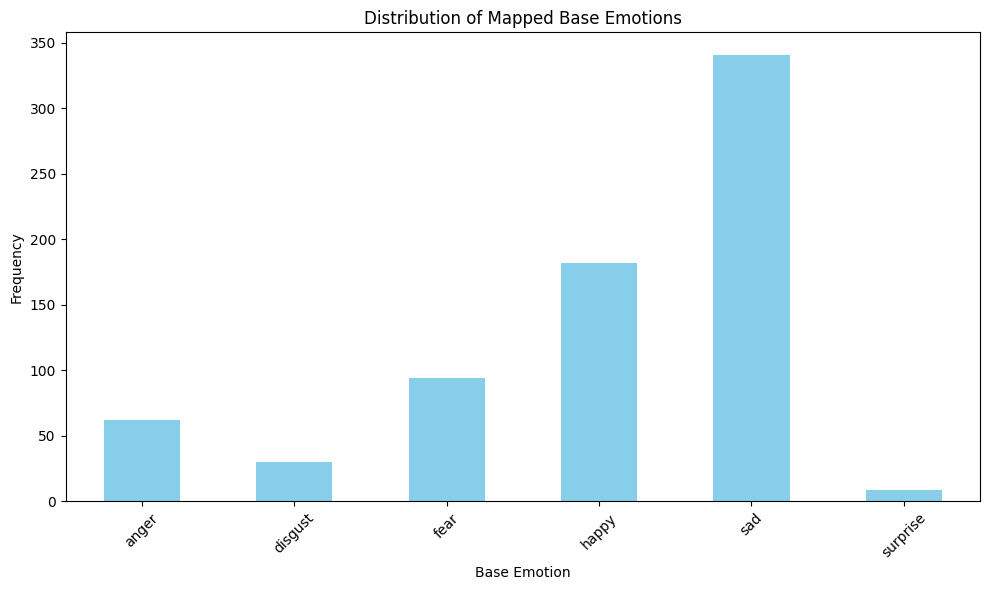

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

emotion_counts = one_hot_encoded_emotions.sum()

plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Mapped Base Emotions')
plt.xlabel('Base Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

base_emotions_dataset = pd.read_csv("/content/base_emotions.csv")

def determine_mental_health(row):
    total_emotions = sum(row.values)
    if total_emotions == 0:
        return '1'
    happy_ratio = row['happy'] / total_emotions
    sad_ratio = row['sad'] / total_emotions
    anger_ratio = row['anger'] / total_emotions
    disgust_ratio = row['disgust'] / total_emotions
    fear_ratio = row['fear'] / total_emotions
    surprise_ratio = row['surprise'] / total_emotions

    happiness_threshold = 0.5
    sadness_threshold = 0.2
    anger_threshold = 0.3
    disgust_threshold = 0.2
    fear_threshold = 0.2
    surprise_threshold = 0.3

    if happy_ratio > happiness_threshold:
        return '1'
    elif (sad_ratio > sadness_threshold) or (anger_ratio > anger_threshold) or (disgust_ratio > disgust_threshold) or (fear_ratio > fear_threshold) or (surprise_ratio > surprise_threshold):
        return '0'
    else:
        return '0'

base_emotions_dataset['mental_health_status'] = base_emotions_dataset.apply(determine_mental_health, axis=1)

print(base_emotions_dataset['mental_health_status'].value_counts())

base_emotions_dataset.to_csv("labeled_base_emotions.csv", index=False)
base_emotions_dataset.head()

mental_health_status
1    845
0    536
Name: count, dtype: int64


,anger,disgust,fear,happy,sad,surprise,mental_health_status
0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

labeled_dataset = pd.read_csv("/content/labeled_base_emotions.csv")

X = labeled_dataset.drop(columns=['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise'])  # Corrected the concatenation
y = labeled_dataset['mental_health_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (1104, 1) (1104,)
Testing data shape: (277, 1) (277,)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from sklearn.metrics import f1_score, accuracy_score, precision_score

data = pd.read_csv("/content/predict (1).csv")
df = pd.DataFrame(data)

label_encoder = LabelEncoder()
df['mental_health_status'] = label_encoder.fit_transform(df['mental_health_status'])

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Emotions'] + " " + df['Causes'])

max_len = max(len(seq) for seq in df['Emotions'] + df['Causes'])
padded_sequences = pad_sequences(tfidf_matrix.toarray(), maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['mental_health_status'], test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=len(tfidf_vectorizer.vocabulary_), output_dim=128, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

y_pred = (model.predict(X_test) > 0.5).astype(int)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Precision: %.2f%%" % (precision*100))

Epoch 1/5
35/35 [==============================] - 147s 4s/step - loss: 0.6704 - accuracy: 0.6141 - val_loss: 0.6718 - val_accuracy: 0.6029
Epoch 2/5
35/35 [==============================] - 109s 3s/step - loss: 0.6711 - accuracy: 0.6141 - val_loss: 0.6751 - val_accuracy: 0.6029
Epoch 3/5
35/35 [==============================] - 113s 3s/step - loss: 0.6696 - accuracy: 0.6141 - val_loss: 0.6745 - val_accuracy: 0.6029
Epoch 4/5
35/35 [==============================] - 113s 3s/step - loss: 0.6667 - accuracy: 0.6141 - val_loss: 0.6739 - val_accuracy: 0.6029
Epoch 5/5
9/9 [==============================] - 4s 503ms/step - loss: 0.6720 - accuracy: 0.6029
Test Accuracy: 0.6028881072998047
9/9 [==============================] - 3s 304ms/step
F1-score: 0.7522522522522522
Accuracy: 0.6028880866425993
Precision: 60.29%


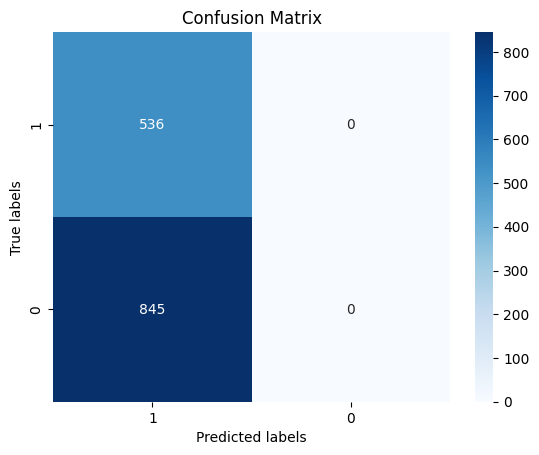

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

base_emotions_dataset = pd.read_csv("/content/labeled_base_emotions.csv")

def determine_mental_health(row):
    total_emotions = sum(row.values)
    if total_emotions == 0:
        return 1
    happy_ratio = row['happy'] / total_emotions
    sad_ratio = row['sad'] / total_emotions
    anger_ratio = row['anger'] / total_emotions
    disgust_ratio = row['disgust'] / total_emotions
    fear_ratio = row['fear'] / total_emotions
    surprise_ratio = row['surprise'] / total_emotions

    happiness_threshold = 0.5
    sadness_threshold = 0.2
    anger_threshold = 0.3
    disgust_threshold = 0.2
    fear_threshold = 0.2
    surprise_threshold = 0.3

    if happy_ratio > happiness_threshold:
        return 1
    elif (sad_ratio > sadness_threshold) or (anger_ratio > anger_threshold) or (disgust_ratio > disgust_threshold) or (fear_ratio > fear_threshold) or (surprise_ratio > surprise_threshold):
        return 0
    else:
        return 0

# Add predicted mental health status to the dataset
base_emotions_dataset['predicted_mental_health_status'] = base_emotions_dataset.apply(determine_mental_health, axis=1)

# Convert predicted mental health status to integer
base_emotions_dataset['predicted_mental_health_status'] = base_emotions_dataset['predicted_mental_health_status'].astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(base_emotions_dataset['mental_health_status'], base_emotions_dataset['predicted_mental_health_status'])

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['1', '0'], yticklabels=['1', '0'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


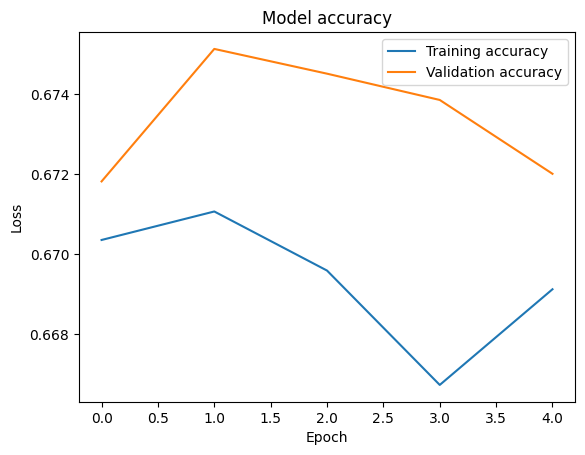

In [ ]:
plt.plot(history.history['loss'], label='Training accuracy')
plt.plot(history.history['val_loss'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model accuracy')
plt.legend()

plt.show()


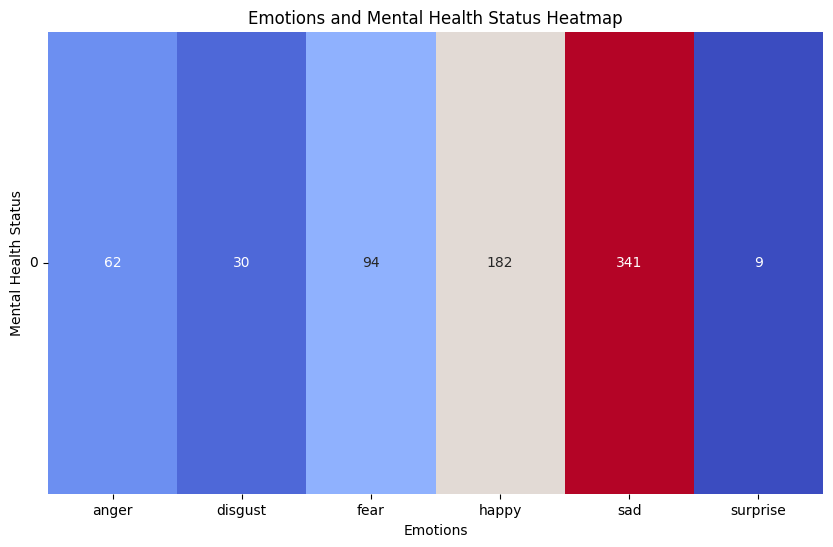

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def determine_mental_health(row):
    numeric_values = [int(val) if str(val).isdigit() else 0 for val in row.values]
    total_emotions = sum(numeric_values)
    if total_emotions == 0:
        return '1'
    else:
        return '0'

base_emotions_dataset['mental_health_status'] = base_emotions_dataset.apply(determine_mental_health, axis=1)

base_emotions_dataset.drop(columns=['predicted_mental_health_status'], inplace=True)

pivot_table = pd.pivot_table(base_emotions_dataset, index='mental_health_status', aggfunc='sum')

plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".0f", cbar=False)

plt.xticks(rotation=0)
plt.yticks(rotation=0)

for text in heatmap.texts:
    if text.get_text() == '1':
        text.set_color('red')

plt.xlabel('Emotions')
plt.ylabel('Mental Health Status')

plt.title('Emotions and Mental Health Status Heatmap')
plt.show()


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.5 MB/s e

In [ ]:
# import necessary libraries
import gradio as gr
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch


emotions_dict = {
    'joy': ['happy', 'joyful', 'pleased', 'cheerful', 'content', 'healthy', 'comfortable', 'better', 'perfect', 'good'],
    'sadness': ['sad', 'unhappy', 'sorrowful', 'mournful', 'melancholy', 'hard', 'sad', 'alone', 'tired', 'wrong', 'overwhelmed', 'upset', 'unable', 'mad', 'lowest', 'bored', 'false', 'sick', 'hard', 'unsure', 'ugly', 'bad', 'worse', 'depression', 'depressed', 'depression', 'depressive', 'hopeless', 'tired', 'pushy', 'upset', 'guilty'],
    'surprise': ['surprise', 'astonished', 'amazed', 'shocked', 'startled', 'sudden', 'strange'],
    'fear': ['fear', 'anxious', 'afraid', 'terrified', 'panicked', 'tense', 'frightened', 'horrible', 'paranoid', 'suicidal', 'worried', 'scared'],
    'disgust': ['disgust', 'dislike', 'repulsed', 'revolted', 'nauseated', 'possessive', 'disgusting', 'annoying', 'annoyed', 'terrible', 'violent', 'ashamed'],
    'anger': ['anger', 'angry', 'irate', 'furious', 'outraged', 'stupid', 'horrible', 'frustrated', 'abusive', 'serious']
}

def get_emotion(input_text):
    inputs = tokenizer(input_text, return_tensors="pt")
    outputs = model(**inputs)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    emotions = {
        0: "joy",
        1: "anger",
        2: "optimism",
        3: "sadness",
        4: "surprise",
        5: "disgust"
    }
    return emotions[predicted_label]

def determine_emotion(input_text):
    input_text = input_text.lower()
    for emotion, keywords in emotions_dict.items():
        for keyword in keywords:
            if keyword in input_text:
                return emotion
    return None

def determine_mental_health_status(emotion):
    if emotion in ['joy', 'optimism']:
        return 'fine'
    else:
        return 'not fine'

def analyze_emotion(input_text):
    detected_emotion = determine_emotion(input_text)
    if detected_emotion:
        mental_health_status = determine_mental_health_status(detected_emotion)
        return f"Detected Emotion: {detected_emotion}\nMental Health Status: {mental_health_status}"
    else:
        emotion = get_emotion(input_text)
        mental_health_status = determine_mental_health_status(emotion)
        return f"Emotion (Pretrained Model): {emotion}\nMental Health Status: {mental_health_status}"
gr.Interface(analyze_emotion, "text", "text", title="Emotion Analysis", theme="default").launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://50ce5390e9c86795fc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


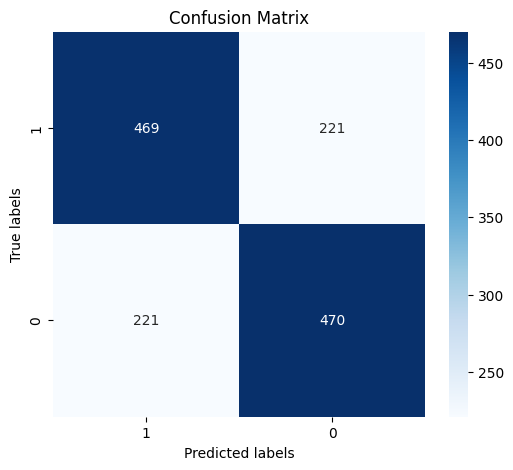

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the confusion matrix
conf_matrix = [[469, 221], [221, 470]]  # [ [TP, FN], [FP, TN] ]

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '0'], yticklabels=['1', '0'])

# Adding labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


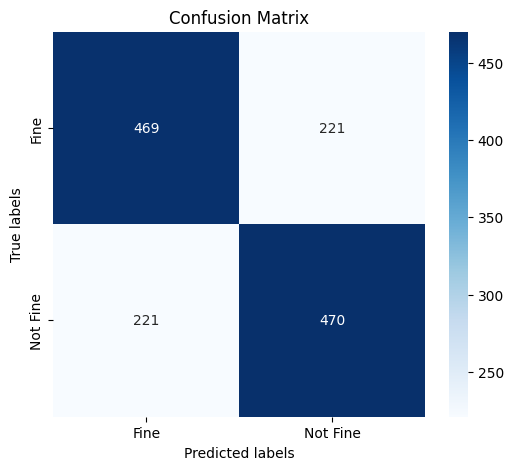

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the confusion matrix
conf_matrix = [[469, 221], [221, 470]]  # [ [TP, FN], [FP, TN] ]

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fine', 'Not Fine'], yticklabels=['Fine', 'Not Fine'])

# Adding labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
